In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import synergy_dataset as sd
from matplotlib.colors import LogNorm

In [ ]:
studies = pd.read_json("synergy_studies_full_val.jsonl", lines=True)
studies_filtered = (
    studies.sort_values("dataset_id")
    .groupby("dataset_id")
    .head(5)
    .reset_index(drop=True)
)

# Compute total relevant counts per dataset
total_relevant_dict = {
    dataset_id: pd.read_csv(f"../datasets/{dataset_id}_shuffled_raw.csv")[
        "label_included"
    ].sum()
    if dataset_id == "Moran_2021_corrected"
    else sum(sd.Dataset(dataset_id).labels.values())
    for dataset_id in studies_filtered["dataset_id"].unique()
}

# Load recall CSVs and ensure matching row counts
recall_files = [
    "recalls_loss_svm.csv",
    "recalls_loss_nb.csv",
    "recalls_ndcg_svm.csv",
    "recalls_ndcg_nb.csv",
    "recalls_old_1-6_nb.csv",
    "recalls_old_nb.csv",
]

recall_types = ["Loss_svm", "Loss_nb", "NDCG_svm", "NDCG_nb", "Old1.6", "Old2.0"]

df_loss_svm, df_loss_nb, df_ndcg_svm, df_ndcg_nb, df_old1_6, df_old = [
    pd.read_csv(f) for f in recall_files
]

# Add dataset name and recall type
for df, recall_type in zip(
    [df_loss_svm, df_loss_nb, df_ndcg_svm, df_ndcg_nb, df_old1_6, df_old], recall_types
):
    df["dataset_name"] = studies_filtered["dataset_id"].values
    df["Optimization"] = recall_type
    df["prior_inclusions"] = studies_filtered["prior_inclusions"].apply(len)
    df["prior_exclusions"] = studies_filtered["prior_exclusions"].apply(len)

# Combine recall data
df_all = pd.concat(
    [df_loss_svm, df_loss_nb, df_ndcg_svm, df_ndcg_nb, df_old1_6, df_old],
    ignore_index=True,
)

# Melt dataframe
df_all_melted = df_all.melt(
    id_vars=["dataset_name", "Optimization", "prior_inclusions", "prior_exclusions"],
    var_name="step",
    value_name="recall",
).dropna()

# Convert step to numeric
df_all_melted["step"] = df_all_melted["step"].astype(int)

# Calculate total relevant items
df_all_melted["total_relevant"] = df_all_melted["dataset_name"].map(total_relevant_dict)

# Recall normalization
df_all_melted["relative_recall"] = df_all_melted["recall"] / np.minimum(
    df_all_melted["total_relevant"] - df_all_melted["prior_inclusions"], 100
)

# Recal @ 100

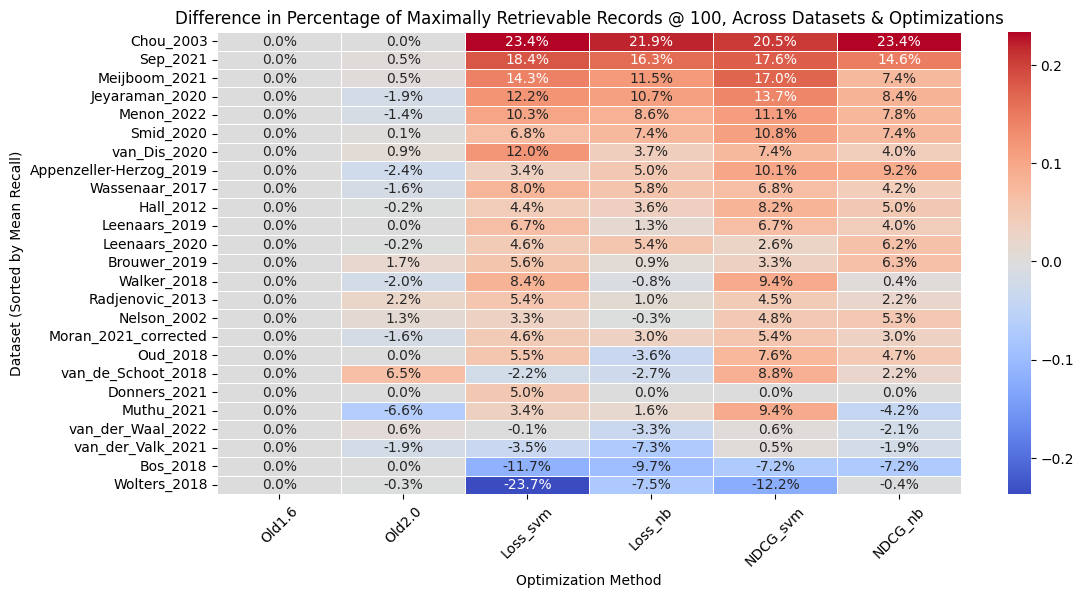

In [ ]:
# Filter data for step 99
df_step_99 = df_all_melted[df_all_melted["step"] == 99]

# Aggregate by mean in case of duplicates
df_step_99 = (
    df_step_99.groupby(["dataset_name", "Optimization"])["relative_recall"]
    .mean()
    .reset_index()
)

# Get the relative recall for 'Old1.6' for each dataset
old1_6_recall = (
    df_step_99[df_step_99["Optimization"] == "Old1.6"]
    .groupby("dataset_name")["relative_recall"]
    .first()
)

# Subtract 'Old1.6' relative recall from all relative recall values
df_step_99["relative_recall_diff"] = df_step_99.apply(
    lambda row: row["relative_recall"] - old1_6_recall[row["dataset_name"]], axis=1
)

# Compute mean recall per dataset for sorting
dataset_mean = (
    df_step_99.groupby("dataset_name")["relative_recall_diff"]
    .mean()
    .sort_values(ascending=False)
)

# Pivot table for heatmap
heatmap_data = df_step_99.pivot(
    index="dataset_name", columns="Optimization", values="relative_recall_diff"
)

# Reorder dataset index based on mean recall
heatmap_data = heatmap_data.loc[dataset_mean.index]

heatmap_data = heatmap_data[
    ["Old1.6", "Old2.0", "Loss_svm", "Loss_nb", "NDCG_svm", "NDCG_nb"]
]

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", linewidths=0.5)
plt.title(
    "Difference in Percentage of Maximally Retrievable Records @ 100, Across Datasets & Optimizations"
)
plt.xlabel("Optimization Method")
plt.ylabel("Dataset (Sorted by Mean Recall)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


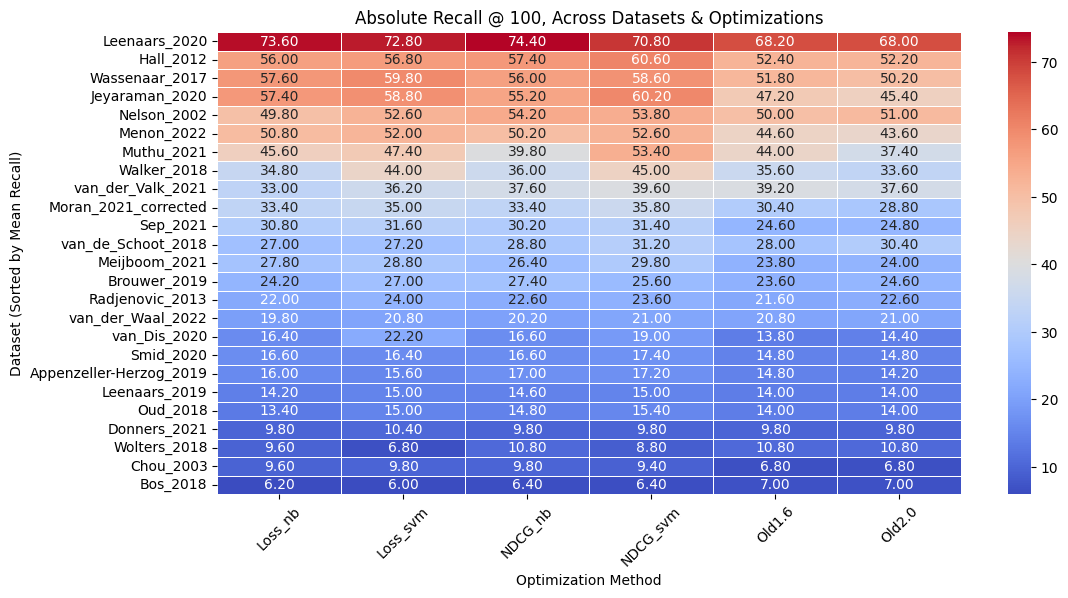

In [ ]:
# Filter data for step 99
df_step_99 = df_all_melted[df_all_melted["step"] == 99]

# Aggregate by mean in case of duplicates
df_step_99 = (
    df_step_99.groupby(["dataset_name", "Optimization"])["recall"].mean().reset_index()
)

# Compute mean recall per dataset for sorting
dataset_mean = (
    df_step_99.groupby("dataset_name")["recall"].mean().sort_values(ascending=False)
)

# Pivot table for heatmap
heatmap_data = df_step_99.pivot(
    index="dataset_name", columns="Optimization", values="recall"
)

# Reorder dataset index based on mean recall
heatmap_data = heatmap_data.loc[dataset_mean.index]

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Absolute Recall @ 100, Across Datasets & Optimizations")
plt.xlabel("Optimization Method")
plt.ylabel("Dataset (Sorted by Mean Recall)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


# Papers Read @ 100%

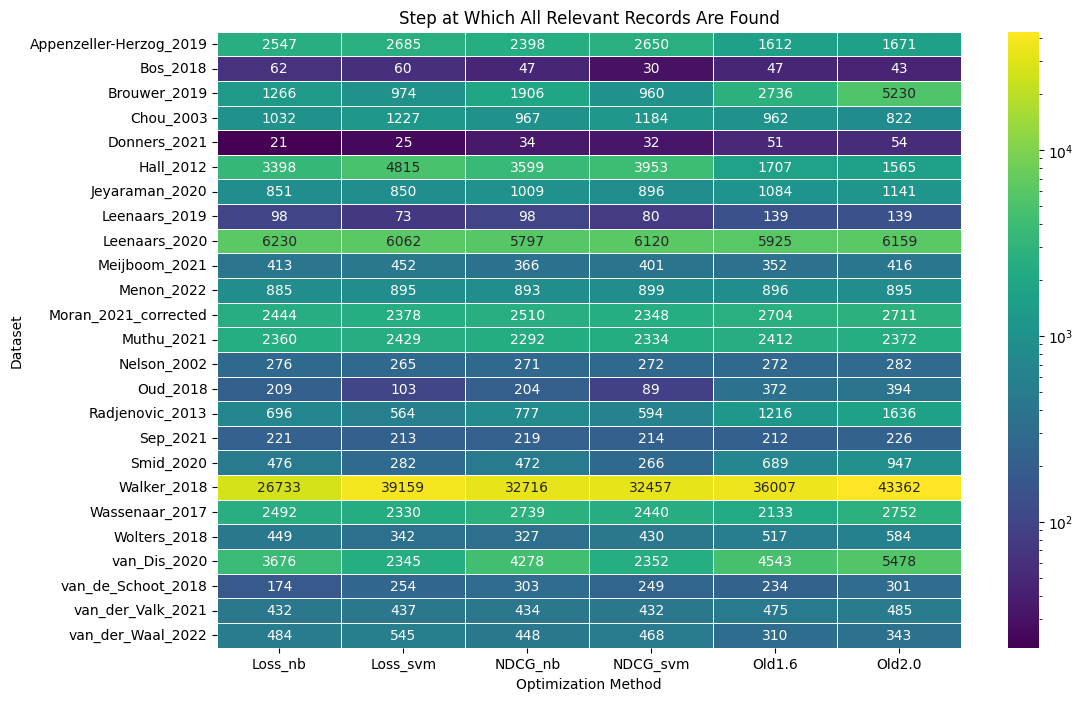

In [ ]:
df_all_melted["target_recall"] = (
    df_all_melted["total_relevant"] - df_all_melted["prior_inclusions"]
)

df_completion_steps = (
    df_all_melted[df_all_melted["recall"] >= df_all_melted["target_recall"]]
    .groupby(["dataset_name", "Optimization"])["step"]
    .min()
    .reset_index()
)

# Pivot table for heatmap
heatmap_data = df_completion_steps.pivot(
    index="dataset_name", columns="Optimization", values="step"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, annot=True, fmt=".0f", cmap="viridis", linewidths=0.5, norm=LogNorm()
)
plt.xlabel("Optimization Method")
plt.ylabel("Dataset")
plt.title("Step at Which All Relevant Records Are Found")
plt.show()


# Papers Read @ 95%

/var/folders/ls/wcyl7trn42jcdp0b2tp0mqqr0000gn/T/ipykernel_7849/1170357418.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_95_steps = df_all_melted.groupby(["dataset_name", "Optimization"]).apply(find_95_index).reset_index(name="step_95")


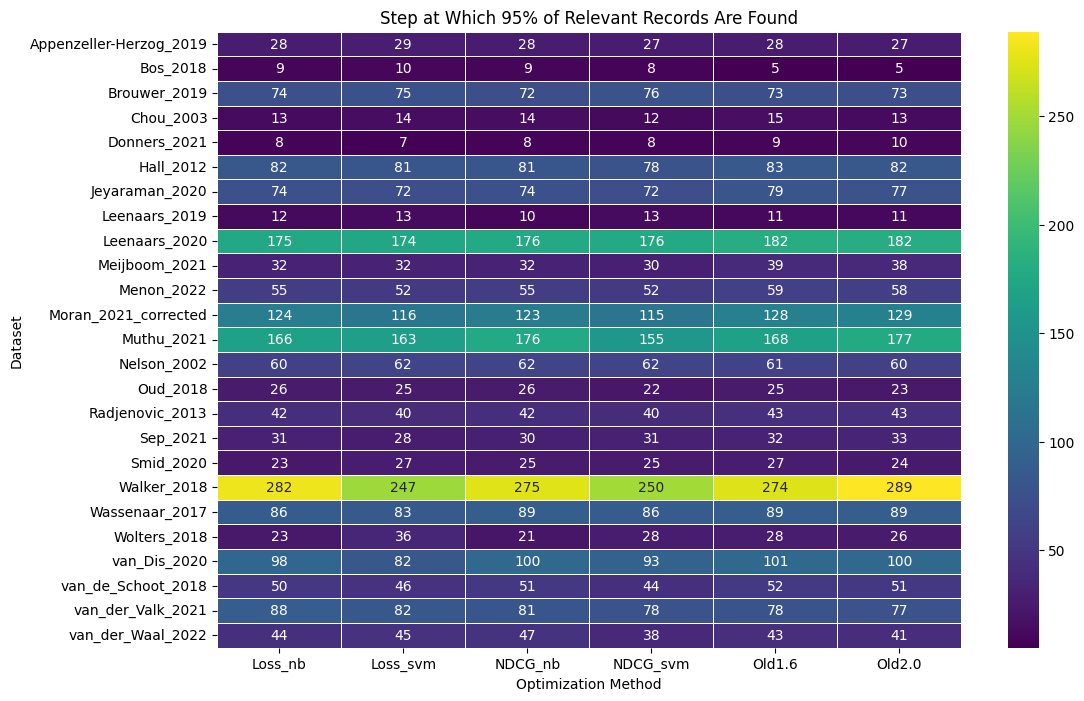

In [ ]:
# Calculate 95% of relevant records
df_all_melted["threshold_95"] = 0.95 * (
    df_all_melted["total_relevant"] - df_all_melted["prior_inclusions"]
)


# Identify at which step 95% of relevant records are found
def find_95_index(group):
    # Find the step at which cumulative recall reaches 95% of relevant records
    group_sorted = group.sort_values("step")
    group_sorted["cumsum_recall"] = group_sorted["relative_recall"].cumsum()
    threshold_step = group_sorted[
        group_sorted["cumsum_recall"] >= group_sorted["threshold_95"]
    ].iloc[0]["step"]
    return threshold_step


df_95_steps = (
    df_all_melted.groupby(["dataset_name", "Optimization"])
    .apply(find_95_index)
    .reset_index(name="step_95")
)
df_95_steps = df_95_steps.pivot(
    index="dataset_name", columns="Optimization", values="step_95"
)

# Visualize with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_95_steps, annot=True, cmap="viridis", fmt=".0f", linewidths=0.5)
plt.xlabel("Optimization Method")
plt.ylabel("Dataset")
plt.title("Step at Which 95% of Relevant Records Are Found")
plt.show()
